In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
Si_O =[12502.905,
 0.43817,
 7.681,
 1459.8331426091827,
 -191.49933785358743,
 1.7009210004687425,
 1.0]
O_O = []

In [2]:
# 生成Table文件 A rho C B D n ro
Si_O = [12702.905, 0.53817, 20.681, 2278.0585428548206, -317.58083271789786, 1.2827443459759618, 1.0040080160320641]
O_O = [1829.2204, 0.53645, 182.58, -40.45358967164747, 166.13382067912485, -5.233911689599193, 1.188376753507014]

###
write_content = ['O2-O2-','O2-Si4+','Si4+Si4+']
# 输出文件位置
file_path = r'C:\Users\81004\Desktop\Table\TABLE-pair1'
# 精度
#######
Number_of_Grids = 10000
Minimum_Cutoff = 0.001
Maximum_Cutoff = 10.00

In [5]:
r_list = np.linspace(Minimum_Cutoff,Maximum_Cutoff,Number_of_Grids)
print(len(r_list))

10000


In [7]:
class ElementPairPotential:
    def __init__(self, pair, A=None, rho=None, C=None, B=None, D=None, n=None, r0=None, charge1=None, charge2=None):
        """
        初始化每个元素对的势函数参数

        Args:
        - pair (str): 元素对名称，例如 "B-O" 或 "O-O"
        - A (float): Buckingham 势的指数项前因子 (eV)
        - rho (float): Buckingham 势的距离参数 (Å)
        - C (float): Buckingham 势的色散项 (eV·Å⁶)
        - B (float): 修正势的幂项前因子 (eV·Åⁿ)
        - D (float): 修正势的平方项前因子 (eV/Å²)
        - n (float): 修正势的幂指数
        - r0 (float): 拼接点 (Å)
        - charge1 (float): 原子 1 的电荷 (单位: e)
        - charge2 (float): 原子 2 的电荷 (单位: e)
        """
        self.pair = pair
        self.A = A
        self.rho = rho
        self.C = C
        self.B = B
        self.D = D
        self.n = n
        self.r0 = r0
        self.charge1 = charge1
        self.charge2 = charge2

    def print_parameters(self):
        """打印参数"""
        print(f"Pair: {self.pair}")
        print(f"  A = {self.A}, rho = {self.rho}, C = {self.C}")
        print(f"  B = {self.B}, D = {self.D}, n = {self.n}, r0 = {self.r0},")
        print(f"  charge1 = {self.charge1}, charge2 = {self.charge2}\n")

In [9]:
# 定义元素对的参数
class_Si_O = ElementPairPotential(
    pair="Si-O",
    A=Si_O[0],
    rho=Si_O[1],
    C=Si_O[2],
    B=Si_O[3],
    D=Si_O[4],
    n=Si_O[5],
    r0=Si_O[6],
    charge1=+2.4,
    charge2=-1.2
)

class_O_O = ElementPairPotential(
    pair="O-O",
    A=O_O[0],
    rho=O_O[1],
    C=O_O[2],
    B=O_O[3],
    D=O_O[4],
    n=O_O[5],
    r0=O_O[6],
    charge1=-1.2,
    charge2=-1.2
)
class_O_O.print_parameters()
class_Si_O.print_parameters()

Pair: O-O
  A = 1829.2204, rho = 0.53645, C = 182.58
  B = -40.45358967164747, D = 166.13382067912485, n = -5.233911689599193, r0 = 1.188376753507014,
  charge1 = -1.2, charge2 = -1.2

Pair: Si-O
  A = 12702.905, rho = 0.53817, C = 20.681
  B = 2278.0585428548206, D = -317.58083271789786, n = 1.2827443459759618, r0 = 1.0040080160320641,
  charge1 = 2.4, charge2 = -1.2



In [15]:
# 定义原始势函数形式
def long_potential(r, para_class):
    A, rho, C,charge1,charge2 = para_class.A,para_class.rho,para_class.C,para_class.charge1,para_class.charge2
    epsilon_0, e_spot, pi = 8.854187817*(10**-12),1.602176634*(10**-19),np.pi
    """计算库伦势"""
    cl = (charge1 * charge2 * e_spot**2 ) / (4*pi*epsilon_0*r) 
    bkh = A * np.exp(-r / rho) - C / r**6
    return cl+bkh

def short_potential(r, para_class):
    B, D, n = para_class.B,para_class.D,para_class.n
    res = B / r**n + D * r**2
    return res
    
def combined_potential(r, para_class):
    """
    计算拼接后的组合势函数
    """
    # 判断使用 Buckingham 势或修正势
    if r > para_class.r0:
        res = long_potential(r, para_class)
    else:
        res = short_potential(r, para_class)
    return res

In [17]:
combined_potential(3.5,class_O_O)

2.5845807742634466

In [29]:
# 定义一阶导形式
# 常数
epsilon_0, e_spot, pi = 8.854187817*(10**-12),1.602176634*(10**-19),np.pi
k0 = e_spot**2/(4*pi*epsilon_0)
# print(k0)
def long_dev_1(r, para_class):
    A, rho, C, charge1, charge2 = para_class.A,para_class.rho,para_class.C,para_class.charge1,para_class.charge2
    """计算 Buckingham 势的一阶导数"""
    coulomb = -(charge1 * charge2 * k0) /  r**2
    exp_term = -(A / rho) * np.exp(-r / rho)
    dispersion = 6 * C / r**7
    return coulomb + exp_term + dispersion
    
def short_dev_1(r,para_class):
    """计算修正势的一阶导数"""
    B, D, n = para_class.B,para_class.D,para_class.n
    return -n * B / r**(n + 1) + 2 * D * r

def combined_dev1(r, para_class):
    if r > para_class.r0:
        res = long_dev_1(r, para_class)
    else:
        res = short_dev_1(r,para_class)
    return res

In [31]:
# 计算二阶导 
def long_dev_2(r, para_class):
    A, rho, C,charge1, charge2 = para_class.A,para_class.rho,para_class.C,para_class.charge1,para_class.charge2
    """计算 Buckingham 势的二阶导数"""
    coulomb = 2 * (charge1 * charge2 * k0) /  r**3
    exp_term = (A / rho**2) * np.exp(-r / rho)
    dispersion = -42 * C / r**8
    return coulomb + exp_term + dispersion
def short_dev_2(r,para_class):
    B, D, n = para_class.B,para_class.D,para_class.n
    """计算修正势的二阶导数"""
    return n * (n + 1) * B / r**(n + 2) + 2 * D


In [35]:
combined_diff1(2.5,class_O_O)

-30.475891287346094

7.32


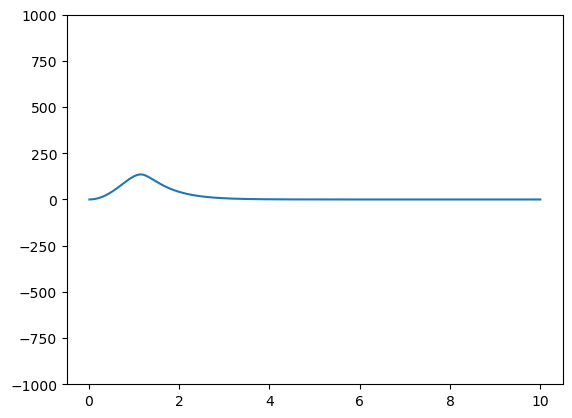

In [27]:
temp = np.linspace(0.01,10,1000)
res = [combined_potential(i,Para_O_O) for i in temp]
plt.plot(temp,res)
plt.ylim(-1000,1000)

for i_r,i_res in zip(temp,res):
    if abs(i_res)<0.001:
        print(i_r)
        break

In [9]:
for count,i_r in enumerate(r_list[:20]):
    print(count,i_r)

0 0.001
1 0.002
2 0.003
3 0.004
4 0.005
5 0.006
6 0.007
7 0.008
8 0.009000000000000001
9 0.010000000000000002
10 0.011
11 0.012
12 0.013000000000000001
13 0.014000000000000002
14 0.015
15 0.016
16 0.017
17 0.018000000000000002
18 0.019000000000000003
19 0.02


In [10]:
# 单个距离的计算
r = 0.8
potential = combined_potential(r, Para_Si_O)
print(f"r = {r:.2f} Å, Potential = {potential:.5f} eV")

# 一组距离的计算
r_values = np.linspace(0.5, 2.5, 10000)
potentials = [combined_potential(r, Para_Si_O) for r in r_values]


r = 0.80 Å, Potential = 2829.77091 eV


In [11]:
save_path = file_path
# 使用 open 函数以写入模式打开文件
file = open(save_path, "w")
###
r_list = np.linspace(Minimum_Cutoff,Maximum_Cutoff,Number_of_Grids)
print(len(r_list))
####
write_content = ['O2-O2-','O2-Si4+','Si4+Si4+']
for section in write_content:
    if section=='O2-O2-':
        class_para = Para_O_O
    if section=='O2-Si4+':
        class_para = Para_Si_O
    # 开始写入
    else:
        class_para=0;
    # 开始写入文件
    file.write(f"{section} \n")
    file.write(f"N {Number_of_Grids} R {Minimum_Cutoff} {Maximum_Cutoff} \n")
    file.write('\n')
    # 如果不是空文件
    if class_para!=0:
        for i_count,i_r in enumerate(r_list):
            i_potential,i_force = combined_potential(i_r, class_para),combined_diff1(i_r,class_para)
            file.write(f'{i_count+1:<5}  {i_r:.5e}  {i_potential:.10e}  {i_force:.10e}\n')
    else:
        for i_count,i_r in enumerate(r_list):
            file.write(f'{i_count+1:<5}  {i_r:.5e}  {0:.10e}  {0:.10e}\n')
    file.write('\n')
# 手动关闭文件
file.close()

10000
